<a href="https://colab.research.google.com/github/shivtejshete/Retail_Analytics/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install kaggle

In [3]:
# Add this to external cookies allowed list   -  [*.]googleusercontent.com:443
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivtejshete","key":"d8a54598045a41f573268a96a799fc38"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d manjeetsingh/retaildataset

  0% 0.00/3.11M [00:00<?, ?B/s]
100% 3.11M/3.11M [00:00<00:00, 105MB/s]


In [6]:
!ls

kaggle.json  retaildataset.zip	sample_data


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('retaildataset.zip' , 'r')
zip_ref.extractall('retail')
zip_ref.close()

In [8]:
os.listdir('/content/retail')

['Features data set.csv', 'stores data-set.csv', 'sales data-set.csv']

In [9]:
import os
root = os.getcwd()

_feature=root+'/retail/'+os.listdir('/content/retail')[0]
_store=root+'/retail/'+os.listdir('/content/retail')[1]
_sales=root+'/retail/'+os.listdir('/content/retail')[2]

In [10]:
import pandas as pd
features = pd.read_csv(_feature)
sales = pd.read_csv(_sales)
stores = pd.read_csv(_store)

In [11]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [12]:
features

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,28/06/2013,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,05/07/2013,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,12/07/2013,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,19/07/2013,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [13]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


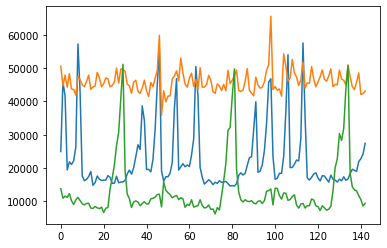

In [14]:
import matplotlib.pyplot as plt

m = sales[(sales.Store==1) & (sales.Dept==1)]
n = sales[(sales.Store==1) & (sales.Dept==2)].reset_index(drop = True)
o = sales[(sales.Store==1) & (sales.Dept==3)].reset_index(drop = True)
plt.plot(m.iloc[:,[3]])
plt.plot(n.iloc[:,[3]])
plt.plot(o.iloc[:,[3]])

In [15]:
#aggregate sales to weekly level inter-store
sales_agg = sales.pivot_table(index=['Store','Date','IsHoliday'], values=['Weekly_Sales'],aggfunc=np.sum).reset_index()

In [16]:
#left join features with sales
merged = pd.merge(features, sales_agg, how='left', on= ['Store', 'Date'], )

In [18]:
merged=merged.loc[:,['Store',
 'Date',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'IsHoliday_x',
 'Weekly_Sales']].merge(stores, how='left', on='Store')

merged.Date = pd.to_datetime(merged.Date)

In [19]:
merged.shape

(8190, 15)

Store           8190
Date            8190
Temperature     8190
Fuel_Price      8190
MarkDown1       4032
MarkDown2       2921
MarkDown3       3613
MarkDown4       3464
MarkDown5       4050
CPI             7605
Unemployment    7605
IsHoliday_x     8190
Weekly_Sales    6435
Type            8190
Size            8190
dtype: int64


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text major ticklabel objects>)

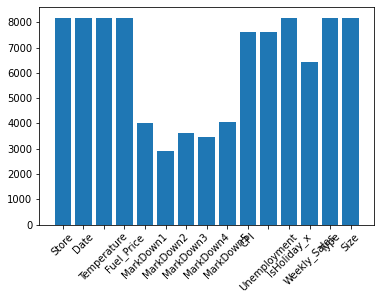

In [20]:
#visualizing non na values in Dataframe for purpose of data quality 
print(merged.count(axis=0))

columns = merged.columns
plt.bar(columns, merged.count(axis=0))
plt.xticks(rotation=45)

* There are two ways we can go about this modeling from now 


1. Takes only records with all values present and then train our model on that dataset
2. Impute the values of all possible feature space variable using imputation methods - and then perform the analysis 
3. Compare the results with both methods and also with different model implementation

* Tree Based Model :
1. This is more suitable for current use-case as there is a non-normal distribution for the feature space 
2. There are number of variables with missing values and Tree based methods can allow missing data  - Denote that as a separate class or a numerical slab and model will recognize the different value
3. They are more comprehensive - except ensembled approaches
4. Computationally expensive but suits our usecase 
5. Cross validation becomes crucial to understand the generalization potential of the model

* Multiple Linear Regression (with regularization L1 or L2 or Elastic):
1. This is more obvious solution but the data present in input feature space is not following the assumptions of Linear Regression model
2. This will be useful if we follow modeling with only most important features ie ones with highest predictability 
3. These are good to explain us a relative importance of different features wrt our response variable

* Deep Learning Model
1. This is a good way to model the given problem but the concern is with the available dataset size and quality 
2. We will try a deep learning method too and its comparison on same dataset vs other models 

Trial 1 - Data Set with Imputation of CPI, Unemployment and Markdown NaN treatment



* Feature Engineering

In [27]:
trail1_raw = merged.dropna().reset_index(drop=True)

In [46]:
print('____________Months________________________________________ : ',[i for i in range(1,13)])
print('Number of Records before Removing NaN records from dataset : ',np.bincount(pd.DatetimeIndex(merged.Date).month ))
print('Number of Records After Removing NaN records from dataset : ', np.bincount(pd.DatetimeIndex(trail1_raw.Date).month ))


____________Months________________________________________ :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Number of Records before Removing NaN records from dataset :  [  0 630 630 720 765 810 675 765 630 630 630 585 720]
Number of Records After Removing NaN records from dataset :  [  0 115 129 178 105   3 146 138 130 138 100 110 103]


In [61]:
#here we are losing alot of useful information due to absence of marketing events into certain weeks of the year
#alternatively we will make sure to assign a value to all those missing marketing drivers - 0, after standardization of those drivers
#before that we will convert the 

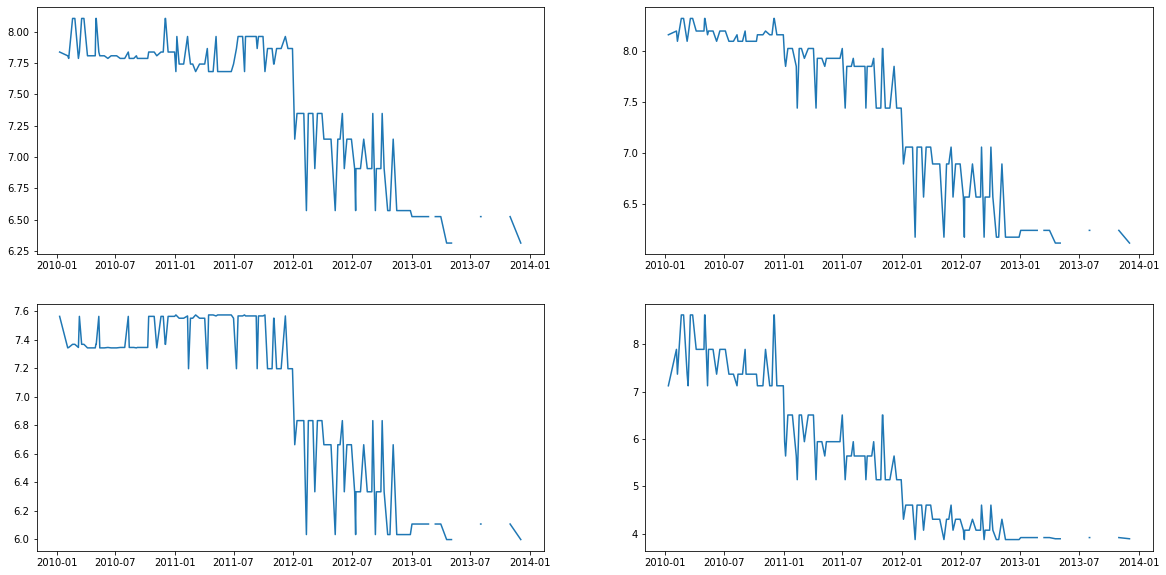

In [104]:
#Imputation of CPI & Unemployment
#both follow store wise different values and they can be inputed with fare amount of accuracy values remain almost nearby 
stores1 = merged.Store.unique()

plt.figure(figsize=(20,10))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.plot(merged[merged.Store==stores1[i]].reset_index(drop=True).sort_values(by='Date').Date,merged[merged.Store==stores1[i]].reset_index(drop=True).sort_values(by='Date').Unemployment )

We can notice that CPI and Unemployment index is changing with respect to each store and so we will need to impute a different value to different store to make sure we keep the data as real as possible

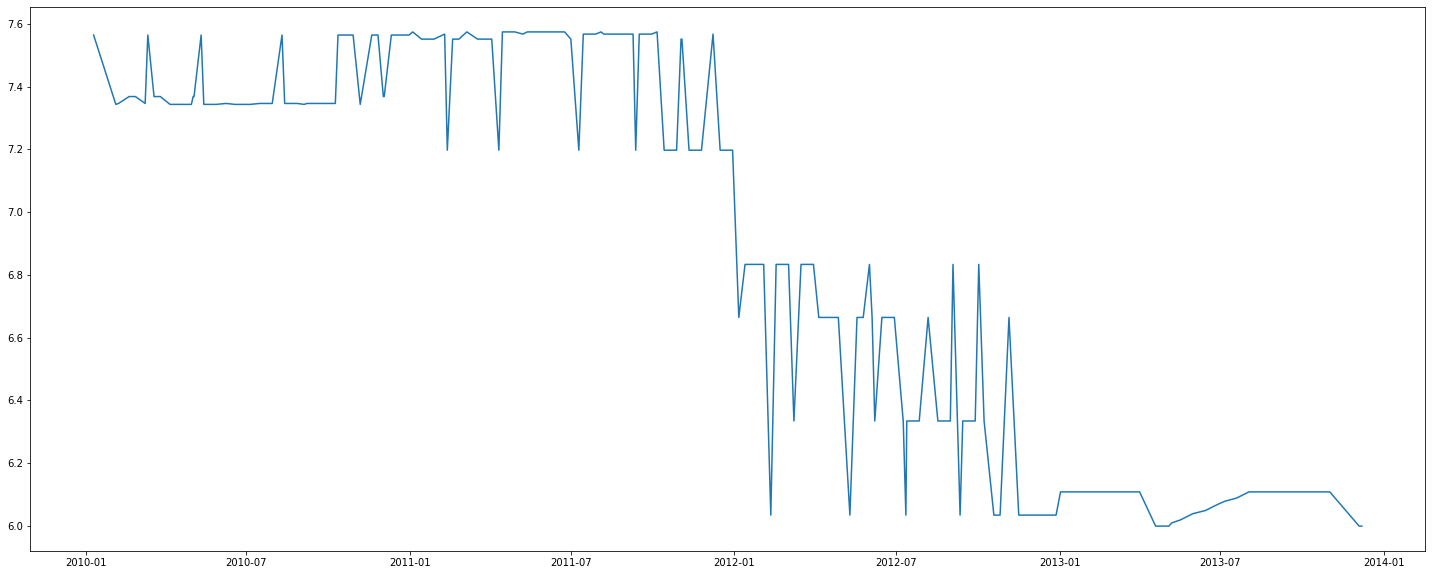

In [90]:
plt.figure(figsize=(25,10))
plt.plot(merged[merged.Store==stores1[2]].reset_index(drop=True).sort_values(by='Date').Date,merged[merged.Store==stores1[2]].reset_index(drop=True).sort_values(by='Date').Unemployment.interpolate())

In [92]:
interpolated = []

def interpolation(df_store):
  """
  This employs interpolation (linear method) on CPI and Unemployment columns and return the dataframe to a list
  Args:
  df_store (pd.DataFrame) : Date sorted unique store Data Frame with Columns CPI and Unemployment
  Returns:
  None
  """
  df_store.CPI= df_store.CPI.interpolate()
  df_store.Unemployment= df_store.Unemployment.interpolate()
  interpolated.append(df_store)
  return None 



In [101]:
interpolation(merged[merged.Store==stores1[i]].sort_values(by='Date').reset_index(drop=True))
# final_interpolated = pd.concat(interpolated) 